In [1]:
from collections import defaultdict
from itertools import product
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

data_folder = 'data/PsychAD_freeze2_personalized_grpahs/processed/'
sns.set_theme()

# Functions

In [2]:
# Analyzing functions
def detect_changing_edges(edgelists):
    # Get binary edges
    binary_edgelists = {k: np.array(v)[:, :2] for k, v in edgelists.items() if len(v) > 0}

    # Filter to uniquely appearing edges (per stage)
    print('Detecting Appearing Edges...')
    binary_unique_edgelists = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 >= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists = {k: np.stack(v) for k, v in binary_unique_edgelists.items()}

    print()
    # Filter to uniquely disappearing edges (per stage)
    print('Detecting Vanishing Edges...')
    binary_unique_edgelists_rev = defaultdict(list)
    for k0, graph0 in binary_edgelists.items():
        print(f'Braak: {k0}', end='')
        num_edges = 0
        for edge in graph0:
            for k1, graph1 in binary_edgelists.items():
                if k1 <= k0:
                    continue
                if edge in graph1:
                    break
            else:  # Only if for loop completes
                binary_unique_edgelists_rev[k0].append(edge)
                num_edges += 1
        print(f' ({num_edges})')
    binary_unique_edgelists_rev = {k: np.stack(v) for k, v in binary_unique_edgelists_rev.items()}
    
    return binary_unique_edgelists, binary_unique_edgelists_rev

def print_edges(edgelists):
    for i, (k, v) in enumerate(edgelists.items()):
        if i != 0:
            print()
        print(f'Braak: {k}')
        print('Top TFs: ', end='')
        genes, counts = np.unique(v[:, 0], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()
        print('Top TGs: ', end='')
        genes, counts = np.unique(v[:, 1], return_counts=True)
        for gene in genes[np.argsort(-counts)][:20]:
            print(f' {gene}', end='')
        print()

def analyze_braak(prefix, suffix):
    edgelists = {}
    for stage in range(7):
        edgelists[stage] = pd.read_csv(prefix + f'{stage:.1f}' + suffix, index_col=0)
    bue, buer = detect_changing_edges(edgelists)
    print('\n' + 30*'-' + '\n')
    print('Appearing Edges...')
    print_edges(bue)
    print('\n' + 30*'-' + '\n')
    print('Vanishing Edges...')
    print_edges(buer)
    
    return edgelists, bue, buer

In [3]:
# Plotting functions
def format_dic(counts_dic):
    # Get all genes
    genes = []
    for k, v in counts_dic.items():
        genes += list(v[0])
    genes = np.unique(genes)

    # Format values
    genes_over_braak = defaultdict(lambda: [])
    for k, v in counts_dic.items():
        for gene in genes:
            count = v[1][np.argwhere(v[0] == gene)]
            if len(count) > 0:
                count = count[0][0]
            else:
                count = 0
            genes_over_braak[gene].append(count)
    genes_over_braak = dict(genes_over_braak)
    
    return genes_over_braak

def get_counts(edgelists):
    tf_counts = {}
    tg_counts = {}
    for k, v in edgelists.items():
        tf_counts[k] = np.unique(v['TF'], return_counts=True)  # val, count
        tg_counts[k] = np.unique(v['TG'], return_counts=True)
    tf_counts = format_dic(tf_counts)
    tg_counts = format_dic(tg_counts)
    
    return tf_counts, tg_counts

def plot_counts(counts, title='Counts by Braak Stage', ylabel='Counts'):
    for k, v in counts.items():
        # Highlight if popular
        color = plt.rcParams['axes.prop_cycle'].by_key()['color'][math.floor(np.log10(np.max(v)))-1]
        # Plot if 7 non-0 values
        if np.sort(v)[0] > 0:
            plt.plot(list(range(7)), v, color=color, label=k)
    plt.yscale('symlog')
    plt.xlabel('Braak Stage')
    plt.ylabel(ylabel)
    plt.title(title)

# Analysis

## Braak

### Cumulative

In [4]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '.csv')

Detecting Appearing Edges...
Braak: 0 (889)
Braak: 1 (1)
Braak: 2 (5)
Braak: 3 (8)
Braak: 4 (284)
Braak: 5 (0)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (1)
Braak: 2 (0)
Braak: 3 (6)
Braak: 4 (1052)
Braak: 5 (0)
Braak: 6 (531)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  RUNX1 FLI1 ZEB1 ETV6 TCF7L2 FOXP2 MAF SOX10 DLX1 TCF7L1 BACH1 SOX5 SOX8 ETS1 ETS2 ARX LHX6
Top TGs:  ARHGAP6 ZFHX3 DISC1 MEF2C NCK2 RIN3 CHST11 MAML3 HS3ST4 DENND3 ZFP36L1 RCSD1 BNC2 LHFPL2 LPAR6 KCNIP1 LPCAT2 LYN LRRK1 LY86

Braak: 1
Top TFs:  JUND
Top TGs:  PTMA

Braak: 2
Top TFs:  MXI1 SOX6
Top TGs:  CADM1 FBXL7 ITGB8 TJP1 ZNF462

Braak: 3
Top TFs:  CREB5 ETV4 JUN STAT1
Top TGs:  CDH19 DHX8 DLG1 FILIP1L ID2 MAP7 PRUNE2 USP54

Braak: 4
Top TFs:  IKZF1 FOS REL SREBF2 ERG JUNB ONECUT2 SPI1 SREBF1
Top TGs:  TFEC SRGN CD4 NCKAP1L C1QB PIK3R5 AAK1 RALGAPA2 RAC1 RAB8B RAB2A QSER1 PYGL PUM1 PTPN22 PTPN2 RAB20 RANBP9 RAP1GAP2 RAPH1

------------------------------

Vanishing Ed

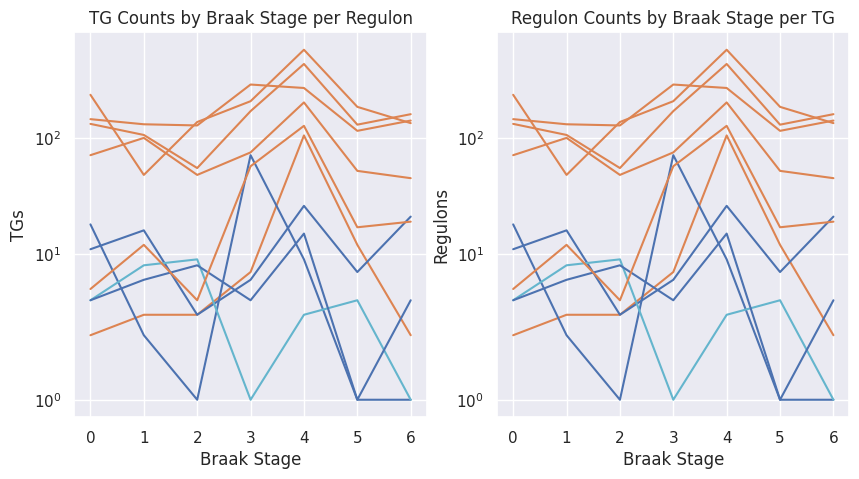

In [5]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### Male

In [6]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '_Sex_Male.csv')

Detecting Appearing Edges...
Braak: 0 (1067)
Braak: 1 (6)
Braak: 2 (161)
Braak: 3 (71)
Braak: 4 (223)
Braak: 5 (0)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (58)
Braak: 4 (894)
Braak: 5 (0)
Braak: 6 (970)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  FLI1 RUNX1 ZEB1 ETV6 TCF7L2 FOXP2 MAF SOX10 TCF7L1 DLX1 LHX6 BACH1 SOX5 ARX SOX8 ETS2 ETS1
Top TGs:  ARHGAP6 ZFHX3 RIN3 MEF2C BNC2 MAML3 DISC1 HS3ST4 FLI1 ARHGAP24 ZNF710 MYO1F RREB1 NCK2 SRGAP2 DENND3 PIAS1 PIK3CD SLC4A7 CHST11

Braak: 1
Top TFs:  RREB1 JUND
Top TGs:  AXL NHSL1 NKX6-2 PTMA TSC22D2 ZFAND6

Braak: 2
Top TFs:  IKZF1 MXI1 FOS REL SREBF1 STAT1 TBL1XR1 CEBPB EGR3 JUNB MEF2C PPARGC1A SOX6
Top TGs:  SRGN TFEC GPR183 KYNU ABHD3 RGS10 RHOH RNF149 RNF166 ROR1 RYR1 SEC24D SF1 SH3TC1 SIPA1L2 SLA SLC2A3 RDX RCOR1 RCC2

Braak: 3
Top TFs:  CREB5 CUX1 ETV4 NR2F1
Top TGs:  ABCG1 PTBP2 PRUNE2 PROX1 POGZ PLEKHH1 PLEKHG3 PTK2 PLD1 PKP4 PHACTR3 PDE4B PDE3A PDE1A NRXN3 PL

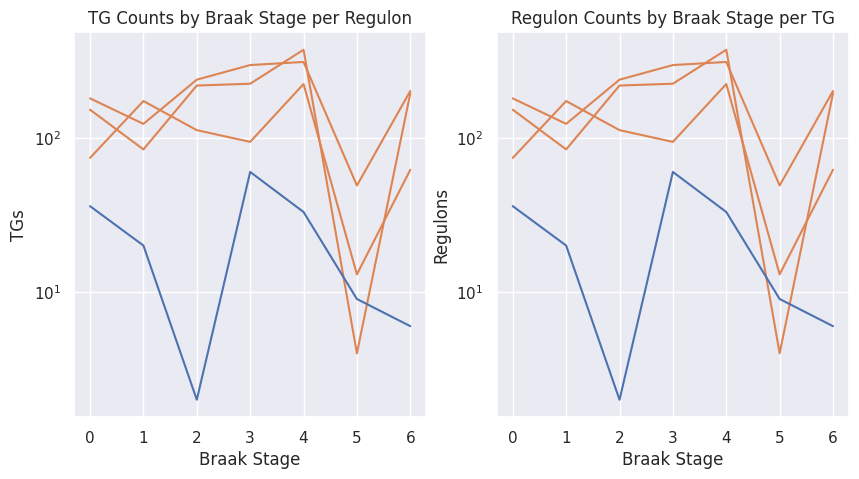

In [7]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### Female

In [8]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_BRAAK_AD_', '_Sex_Female.csv')

Detecting Appearing Edges...
Braak: 0 (779)
Braak: 1 (25)
Braak: 2 (0)
Braak: 3 (13527)
Braak: 4 (0)
Braak: 5 (0)
Braak: 6 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 2 (0)
Braak: 3 (11676)
Braak: 4 (806)
Braak: 5 (8)
Braak: 6 (427)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  FLI1 TCF7L2 RUNX1 ZEB1 ETV6 SOX10 ETS2 MAF FOXP2 ETS1 SOX8 SOX5 BCL6 MXI1 EGR3 TCF7L1 JUND RREB1 HLF BACH1
Top TGs:  PRKCH CHST11 ARHGAP6 MEF2C DISC1 ARHGEF6 DENND3 EPAS1 MEF2A BNC2 P2RY12 HERC2P3 SLC4A7 UTRN FLI1 SLCO2B1 MAML3 GNB4 LYN TBC1D4

Braak: 1
Top TFs:  LHX6 DLX1 ARX STAT1
Top TGs:  GAD2 ANK1 THSD7B SULF1 SLIT2 RAB3B PRDM1 PPARG PHACTR2 LRP8 IGF1 HUNK GRIK3 FILIP1L ELAVL2 DLX1 CRTAC1 CCNJL CACNA2D2 C8orf34

Braak: 3
Top TFs:  IKZF1 FOXO1 ELF1 TBR1 FOS LEF1 RFX1 KLF8 JUNB CPEB1 CEBPB ERG KLF6 GLIS1 ANXA11 SREBF1 NPAS2 PBX3 BHLHE40 NR2F1
Top TGs:  SOCS2 LEF1 ZIC5 IGFBP5 CUX2 HAO2 PPP1R1C CHRM2 CSF1R CDK18 DDN PIK3AP1 WDFY4 ARHGAP25 EXPH5 SYK DPYSL5 HRH2 SLC

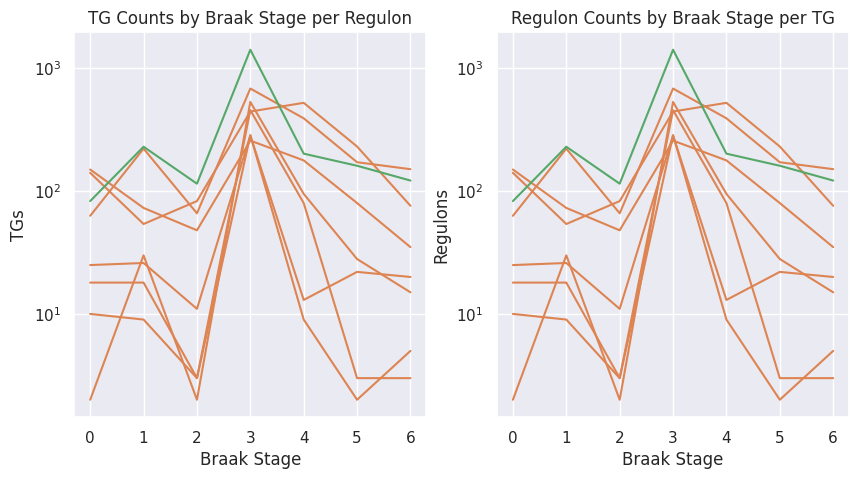

In [9]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### EN

#### Male

In [10]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_EN_BRAAK_AD_', '_Sex_Male.csv')

Detecting Appearing Edges...
Braak: 0 (2)
Braak: 2 (16)
Braak: 3 (0)
Braak: 4 (26)
Braak: 5 (0)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 2 (0)
Braak: 3 (0)
Braak: 4 (103)
Braak: 5 (1)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  ARNTL2 EGR3
Top TGs:  EPB41L4B SLCO2A1

Braak: 2
Top TFs:  GLIS1 TBR1 HLF
Top TGs:  BCL11A CABP1 CACNA1E DPY19L2P1 GFRA2 GRM1 KCNQ5 LNX1 NRG1 NRGN OLFM3 PRR16 PTPRB SATB2 SLC8A2 ZNF804B

Braak: 4
Top TFs:  ONECUT2 CUX2 EMX1 FOXP1 MEIS3 ZNF831
Top TGs:  ART3 SV2B SH3RF2 SEMA5B PDGFD NEUROD2 LIN28B KIAA1217 ITPKA HTR3B GYPE GULP1 EMX1 DCLK3 CUX2 CTXN3 COL24A1 CHST8 CDH9 CDH12

------------------------------

Vanishing Edges...
Braak: 4
Top TFs:  ARNTL2 HLF ONECUT2 CUX2 EMX1 EGR3 ZNF831 FOXP1 MEIS3 TBR1
Top TGs:  SATB2 CDH22 CUX2 DDN ADAMTS3 RBFOX3 TLL1 NEUROD2 CA10 NPTX1 PPFIA4 PKIG PHYHIP PDGFD PART1 ADAMTS16 NRG1 PRKCG NGEF NEFL

Braak: 5
Top TFs:  GLIS1
Top TGs:  GDA


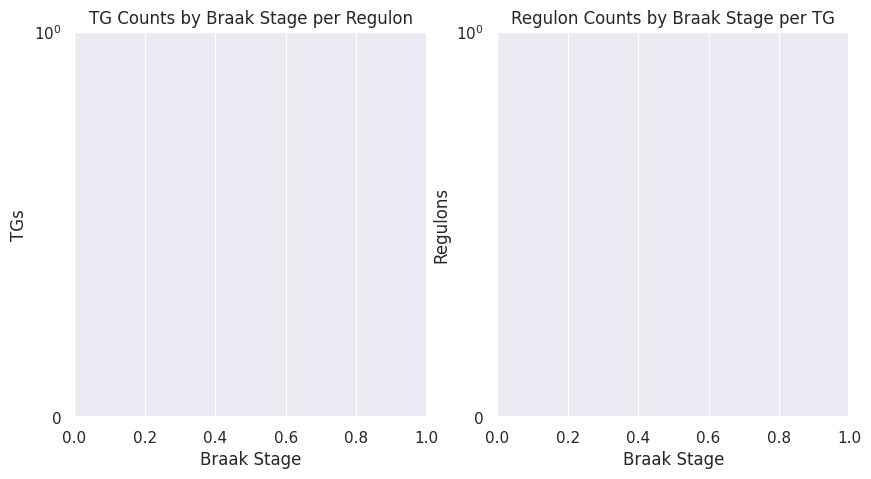

In [11]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

#### Female

In [12]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_EN_BRAAK_AD_', '_Sex_Female.csv')

Detecting Appearing Edges...
Braak: 0 (4)
Braak: 1 (4)
Braak: 3 (200)
Braak: 4 (2)

Detecting Vanishing Edges...
Braak: 0 (0)
Braak: 1 (0)
Braak: 3 (194)
Braak: 4 (30)

------------------------------

Appearing Edges...
Braak: 0
Top TFs:  EGR3 ARNTL2 TBR1
Top TGs:  KCNV1 NRN1 PTPN3 SLC30A3

Braak: 1
Top TFs:  ONECUT2
Top TGs:  ADAMTS3 CUX2 HTR3B ZBBX

Braak: 3
Top TFs:  ARGFX KLF8 PAX2 VAX2 FOXP1 HNF4A RARA EGR1 ZNF214 EMX1 TWIST1 BRF2 TEAD4 ZNF184 NFIL3 MEF2D NR2E3
Top TGs:  CCDC68 KCNG1 FGF10 ITGA4 DPY19L2P4 FAM163A FAM169B CD8B LIN28B MUC15 GPR88 KC6 MAS1 KCNA4 PNPLA3 PON3 PORCN PRRT4 PRX PNMA5

Braak: 4
Top TFs:  GLIS1 HLF
Top TGs:  SLIT1 SYT7

------------------------------

Vanishing Edges...
Braak: 3
Top TFs:  ARGFX KLF8 VAX2 PAX2 FOXP1 HNF4A RARA EGR1 ZNF214 TWIST1 BRF2 EMX1 TEAD4 NFIL3 ZNF184 MEF2D NR2E3
Top TGs:  CCDC68 KCNG1 FGF10 ITGA4 GPR88 CD8B MUC15 MAS1 KCNA4 KC6 LIN28B DPY19L2P4 FAM169B PRRT4 PORCN PRX PON3 PTGIS PNPLA3 PNMA5

Braak: 4
Top TFs:  ARNTL2 ONECUT2 EGR3 TBR

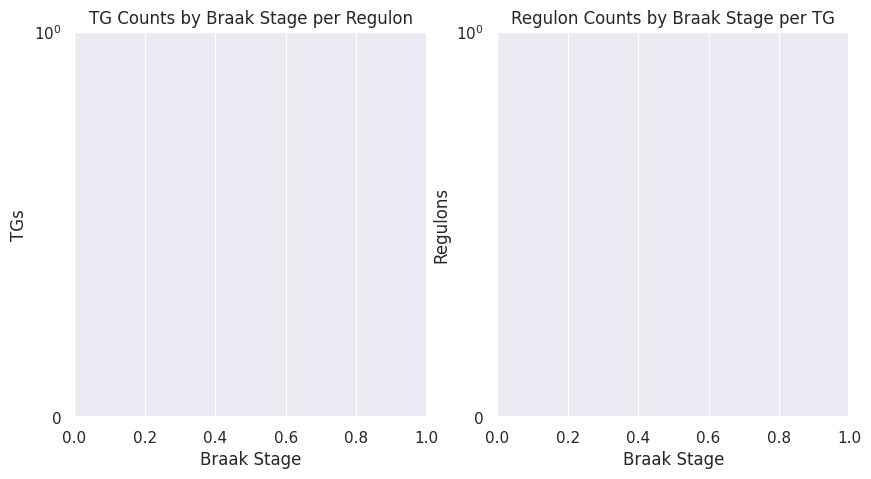

In [13]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

### IN

#### Male

In [14]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_IN_BRAAK_AD_', '_Sex_Male.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/PsychAD_freeze2_personalized_grpahs/processed/grn_IN_BRAAK_AD_1.0_Sex_Male.csv'

In [ ]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

#### Female

In [ ]:
# Analysis
edgelists, bue, buer = analyze_braak(data_folder + 'grn_IN_BRAAK_AD_', '_Sex_Female.csv')

In [ ]:
# Plotting
tf_counts, tg_counts = get_counts(edgelists)
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
plot_counts(tf_counts, title='TG Counts by Braak Stage per Regulon', ylabel='TGs')
plt.sca(axs[1])
plot_counts(tf_counts, title='Regulon Counts by Braak Stage per TG', ylabel='Regulons')

# Other